### Qiskit Fall Fest - Understanding and Mitigating Quantum Noise
🏁 Introduction: Why We Need Error Mitigation
Welcome! In this notebook, we'll tackle the single biggest challenge in quantum computing today: **noise**.

Computers in the Noisy Intermediate-Scale Quantum (NISQ) era are powerful but imperfect. Qubits "forget" their state, gates aren't 100% accurate, and even *looking* at a qubit can give the wrong answer.

This notebook will be your guide, broken into 6 simple sections:

1.  **The "Ideal" Quantum World:** What *should* happen in a perfect world.
2.  **Meet the Enemy - What is Noise?** A simple, conceptual guide.
3.  **Seeing is Believing - Simulating Noise:** We'll break our perfect circuit.
4.  **Mitigation 1: Fighting Readout Noise:** How to fix "measurement lies."
5.  **Mitigation 2: Fighting Gate Noise:** How to fix "clumsy" operations.
6.  **The "Easy Button":** How to do all this automatically.

Let's get started!

In [22]:
# Qiskit and Helper Libraries 

# Qiskit main components
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2 # Generic fake backend

# Qiskit Aer for noise simulation
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, ReadoutError, depolarizing_error,
                                thermal_relaxation_error)

# Qiskit Primitives (the modern way to run circuits)
#from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import SparsePauliOp
#from qiskit.utils.mitigation import CompleteMeasFitter
# Qiskit Measurement Mitigation Tools
#from qiskit.mitigation.measurement import (CompleteMeasFitter, tensored_meas_cal)
#from qiskit.mitigation import MeasurementFilter
from qiskit_aer.noise import (NoiseModel, ReadoutError, depolarizing_error,
                                thermal_relaxation_error)
from qiskit.visualization import plot_histogram
# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Section 1: The "Ideal" Quantum World (Our Goal)

Before we see what breaks, let's see what *should* happen. We will create one of the most famous quantum circuits: a **Bell State**. This "perfect" result is our **ground truth**.

### 📖 Key Definitions: The Building Blocks

* **Qubit (Quantum Bit):** A basic unit of quantum information. Unlike a classical bit (which is 0 *or* 1), a qubit can be in a state of 0, 1, or both at the same time. We write these states as $|0\rangle$ and $|1\rangle$.

* **Superposition:** The ability of a qubit to be in a combination of $|0\rangle$ and $|1\rangle$ simultaneously. When we apply a **Hadamard (H) gate** (`.h()`), we put a qubit from state $|0\rangle$ into an equal superposition of $|0\rangle$ and $|1\rangle$.

* **Entanglement:** A special connection between two or more qubits. If two qubits are entangled, their states remain linked no matter how far apart they are. Measuring one instantly influences the possible outcome of measuring the other. A **CNOT (CX) gate** (`.cx()`) is a 2-qubit gate that we use to create entanglement.

* **Quantum Circuit (`QuantumCircuit`):** An object that holds our "recipe" of quantum operations. We add gates to it in sequence, just like writing lines of code, to build our algorithm.

* **Measurement:** The act of "looking" at a qubit, which forces it to "choose" a classical state, collapsing its superposition into either a 0 or a 1.

* **Simulator (`AerSimulator`):** A classical program that *pretends* to be a quantum computer. `qiskit_aer` is Qiskit's high-performance simulator. The "ideal" simulator we use here has *no noise* and gives the perfect, mathematically correct answer.

* **Shots:** The number of times we run the *exact same circuit* and record the measurement. Since quantum mechanics is probabilistic, we run it many times (e.g., 1000 "shots") to build up statistics of the results.

* **Counts:** A Python dictionary that shows the results of our "shots." The keys are the bitstrings we measured (like '00' or '01'), and the values are how many times (out of 1000 shots) we got that result.

---

### 🔬 The "Perfect" Experiment

Now let's use these pieces. We will create a Bell State to entangle two qubits. When measured, an entangled Bell State should *only* give '00' or '11' as the answer, each with 50% probability. You should *never* get '01' or '10'.

Running on perfect simulator...
Perfect Counts: {'00': 500, '11': 500}


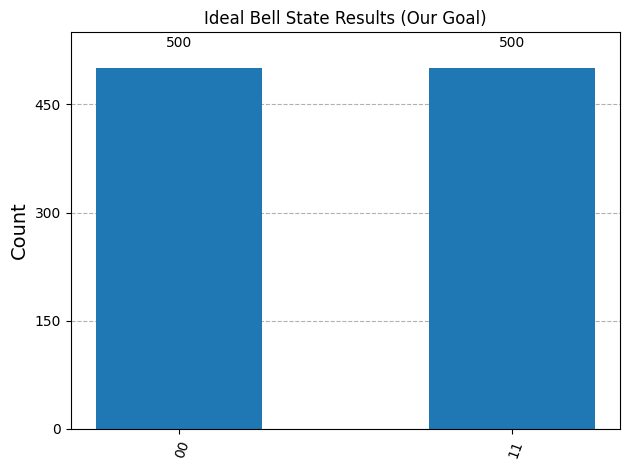

In [50]:
# 1. Create a Bell State circuit
# We initialize a QuantumCircuit with 2 qubits
bell_circ = QuantumCircuit(2)

# Apply a Hadamard gate to qubit 0 to create superposition
bell_circ.h(0)     

# Apply a CNOT gate from qubit 0 to 1 to create entanglement
bell_circ.cx(0, 1) 

# Add a measurement "instruction" to all qubits
bell_circ.measure_all() 

# 2. Get the "Ideal" simulator (no noise)
ideal_sim = AerSimulator()

# 3. Run the circuit 1000 times
print("Running on perfect simulator...")
# .run() takes the circuit and shots, and returns a "job"
ideal_job = ideal_sim.run(bell_circ, shots=1000)

# We ask the job for the results
ideal_counts = ideal_job.result().get_counts()

# 4. Plot the perfect results
print(f"Perfect Counts: {ideal_counts}")
plot_histogram(ideal_counts, 
               title='Ideal Bell State Results (Our Goal)')

Beautiful! As expected, we only get '00' and '11', with a near 50/50 split. This perfect histogram is the "right answer." Now, let's learn about the noise that will break this.

## Section 2: Meet the Enemy - What is Quantum Noise? 🧠

"Noise" is anything that causes our quantum system to deviate from this perfect picture.

### An Analogy: The Spinning Coin

Imagine a qubit is a coin.
* $|0\rangle$ is the coin lying flat, **Heads** up. (This is the "ground state" or lowest energy state).
* $|1\rangle$ is the coin lying flat, **Tails** up. (This is the "excited state" or highest energy state).
* A **superposition** is the coin **spinning** perfectly on its edge.

Now, let's see how noise affects it:

**1. $T_1$ (Relaxation) Error:**
* **Definition:** The "excited" $|1\rangle$ state is not stable. It will eventually lose energy and "relax" or "decay" back to the stable $|0\rangle$ state. The $T_1$ time is the *average* time it takes for this to happen.
* **Analogy:** Your spinning coin (or your Tails-up coin) is unstable. After a while, it *loses energy* and falls over, always landing on **Heads** ($|0\rangle$). A short $T_1$ time means it falls over very quickly.

**2. $T_2$ (Dephasing) Error:**
* **Definition:** This error destroys superposition. It's a loss of "phase" information. The $T_2$ time is the *average* time a qubit can *stay* in superposition before its phase is randomized.
* **Analogy:** Your coin is spinning perfectly. A small breeze (noise) makes it *wobble*. It's still spinning (it hasn't relaxed, $T_1$), but the wobble means its "quantum-ness" is scrambled. A short $T_2$ time means it starts wobbling very
    quickly.

**3. Gate Error:**
* **Definition:** A quantum gate is an operation, like a laser pulse, that is supposed to be perfect (e.g., rotate the qubit by exactly 90°). A gate error means the operation is flawed (e.g., it only rotates 89.9°).
* **Analogy:** You try to flip the coin from Heads to Tails (a perfect X-gate). But, you're clumsy and only flip it 178°. It's *almost* Tails, but not quite. This small error builds up over many gates.

**4. Readout Error:**
* **Definition:** A measurement error where the detector *mis-reports* the qubit's final state. It *sees* a 0 but *reports* a 1, or vice-versa.
* **Analogy:** The coin lands perfectly on Heads ($|0\rangle$). You look at it, but the light is bad, and you *write down* "Tails" ($|1\rangle$) in your notebook.

Now, let's see what this *looks* like in code.

## Section 3: Seeing is Believing - Simulating Noise 💥

We'll take our *perfect* Bell State from Section 1 and run it on a **noisy simulator**.

### 📖 Key Definitions: Simulating Noise

* **`FakeBackend` (`FakeManilaV2`):** A data object that stores all the *real*, calibrated noise properties ($T_1$, $T_2$, gate errors, readout errors) from a specific, real-world IBM Quantum chip. It's a "snapshot" of a real device.
* **`NoiseModel`:** A Qiskit object that holds a collection of noise instructions. When we load a `FakeBackend`, Qiskit builds a complete `NoiseModel` from its properties.
* **`AerSimulator.from_backend(backend)`:** This is our "easy button" for creating a noisy simulator. It tells `AerSimulator` to load the `FakeBackend`, build the `NoiseModel`, and configure itself to behave *exactly* like that real, noisy chip.
* **`transpile(circuit, backend)`:** The "compile" step. This function rewrites our simple, abstract `QuantumCircuit` (with 'h' and 'cx') into a new circuit that *only* uses the *native gates* the real hardware understands (e.g., 'rz', 'sx', 'ecr'). This is **critical** for noisy simulation, as the noise model is defined *for those native gates*.

---

### 🔬 The "Noisy" Experiment

Loaded backend: generic_backend_2q
Created noisy simulator from backend.

Running on REALISTIC noisy simulator...
Noisy Counts: {'11': 502, '00': 487, '01': 3, '10': 8}


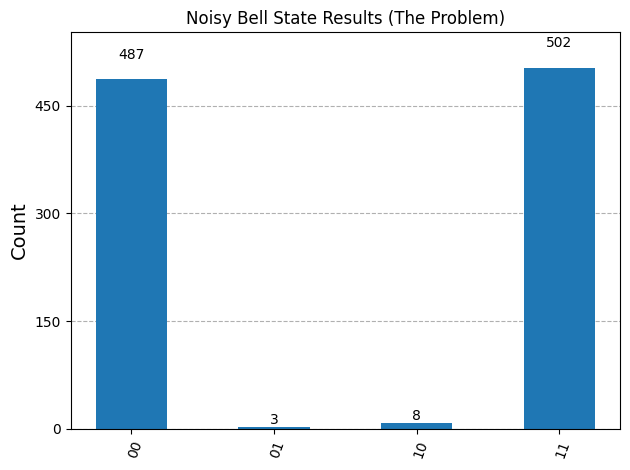

In [51]:
# 1. Load the fake backend
# This contains all the real error data for the 'ibmq_manila' chip
backend_real = GenericBackendV2(num_qubits=2)
print(f"Loaded backend: {backend_real.name}")

# 2. Create an AerSimulator that mimics this backend's noise
sim_real_noisy = AerSimulator.from_backend(backend_real)
print("Created noisy simulator from backend.")

# 3. We use the *same* Bell circuit from Section 1
print("\nRunning on REALISTIC noisy simulator...")

# 4. We MUST transpile the circuit for the noisy simulator
# This maps 'h' and 'cx' to the backend's real, noisy gates
transpiled_bell_noisy = transpile(bell_circ, sim_real_noisy)

# 5. Run the *transpiled* circuit
real_job = sim_real_noisy.run(transpiled_bell_noisy, shots=1000)
real_counts = real_job.result().get_counts()

# 6. Plot the noisy results
print(f"Noisy Counts: {real_counts}")
plot_histogram(real_counts, 
               title='Noisy Bell State Results (The Problem)')

### Exercise 1: Compare the Ideal vs. Noisy

Look at that result! It's a mess. We have '01' and '10' bars, which are *wrong*. And the '00' and '11' bars aren't 50/50. This is the problem of noise.

**Task:** Plot the `ideal_counts` (from Section 1) and `real_counts` (from this section) on the **same histogram** to see the problem side-by-side.

### ✏️ Your Answer

In [ ]:
# --- Your Code Goes Here ---
# Plot both ideal_counts and real_counts
# on a single histogram.
plot_histogram([..., ...], 
               legend=['Ideal', 'Noisy'],
               title='Ideal vs. Noisy Results')

### 💡 Solution

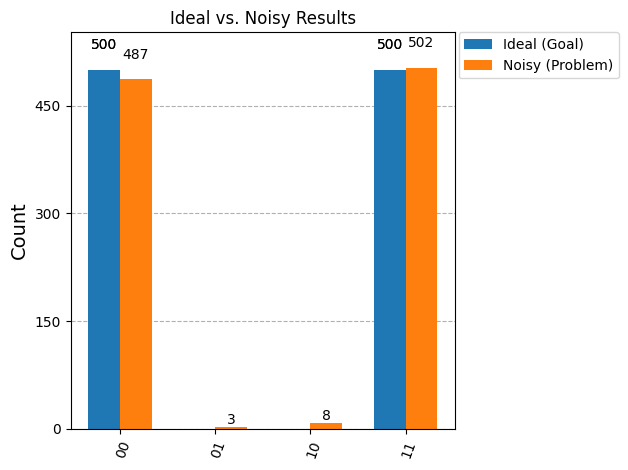

In [52]:
# --- Solution Code ---
plot_histogram([ideal_counts, real_counts], 
               legend=['Ideal (Goal)', 'Noisy (Problem)'],
               title='Ideal vs. Noisy Results')

This plot is the entire reason for this notebook. The rest of our work is about one thing: **How do we make the "Noisy" bars look like the "Ideal" bars?**

# Section 4: Mitigation 1 - Fighting Readout Noise 🔍
In the previous section, we saw that our results were "noisy." A large part of this error comes from the measurement device itself. This is called Readout Error.

Think of it like a pair of dirty glasses: you might look at a 0, but because of the smudge, you accidentally see a

### 📖 Key Definitions: Measurement Mitigation
- Quantum Error Mitigation (QEM): A collection of software techniques that don't fix the hardware errors, but estimate what the noise-free answer should be mathematically.

- Calibration Circuits: A set of simple circuits where we prepare states we know with 100% certainty (like $|00\rangle, |01\rangle, |10\rangle, |11\rangle$). We run these to see how often the quantum computer "lies" to us.

- Confusion Matrix ($M$): A table that maps "Truth" to "Measurement.

- "If we prepare $|00\rangle$ and measure 00 90% of the time and 01 10% of the time, we record that in the matrix.
- The Diagonal represents correct answers.

- The Off-Diagonal elements represent the errors (the "lies").The 
- Filter ($M^{-1}$): If we know the matrix of errors ($M$), we can calculate its mathematical inverse ($M^{-1}$). Multiplying our noisy results by this inverse matrix "undoes" the noise.

🔬 The Experiment WorkflowCalibrate: Run reference circuits for all basis states (00, 01, 10, 11).Map: Build the Confusion Matrix ($M$) from those results.Invert: Calculate the inverse matrix ($M^{-1}$).Apply: Take our real, noisy data from Section 3 and multiply it by $M^{-1}$ to clean it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Setup the backend
backend = FakeManilaV2()

# Re-create our Noisy Bell State Experiment (from Section 3 context)
# We need some "bad" data to fix!
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
transpiled_bell = transpile(bell, backend)
job_bell = backend.run(transpiled_bell, shots=1000)
noisy_counts = job_bell.result().get_counts()
ideal_counts = {'00': 500, '11': 500} # For comparison

In [ ]:
# 1. Generate the calibration circuits 
# We need to measure the error on 00, 01, 10, and 11 explicitly.
cal_circuits = []
labels = ['00', '01', '10', '11']

for label in labels:
    qc = QuantumCircuit(2)
    # If label is '10', we put X on qubit 1. If '01', X on qubit 0.
    if label[0] == '1': qc.x(1)
    if label[1] == '1': qc.x(0)
    qc.measure_all()
    cal_circuits.append(qc)

# --- 2. Run them on our noisy backend ---
print(f"Running {len(cal_circuits)} calibration circuits...")
transpiled_cal = transpile(cal_circuits, backend)
cal_job = backend.run(transpiled_cal, shots=1000)
cal_results = cal_job.result()
print("Calibration complete.")

Running 4 calibration circuits...
Calibration complete.


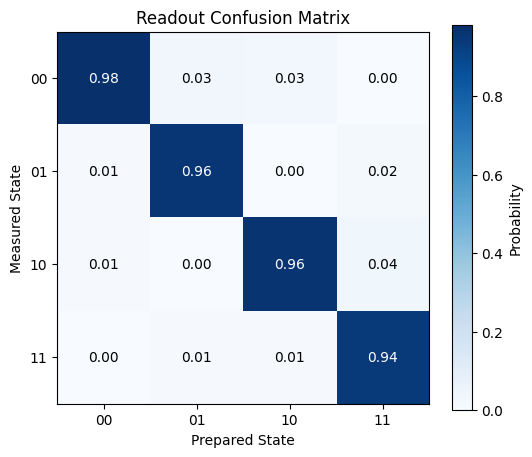

In [ ]:
# 3. Build the Confusion Matrix (The "Map of Lies") 
# Matrix M where M[i][j] is Prob(measuring i | prepared j)
M = np.zeros((4, 4))

for i, prepared_label in enumerate(labels):
    # Get counts for this specific calibration circuit
    counts = cal_results.get_counts(i)
    total_shots = sum(counts.values())
    
    for j, measured_label in enumerate(labels):
        # Calculate probability: Count / Total
        M[j][i] = counts.get(measured_label, 0) / total_shots

# Plotting the Matrix
plt.figure(figsize=(6, 5))
plt.imshow(M, interpolation='nearest', cmap='Blues')
plt.title("Readout Confusion Matrix")
plt.xlabel("Prepared State")
plt.ylabel("Measured State")
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.colorbar(label="Probability")

# Add numbers to the heatmap
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{M[i][j]:.2f}", ha="center", va="center", color="black" if M[i][j] < 0.5 else "white")

plt.show()

Instructor Note: We use scipy.linalg.inv to invert the matrix ($M^{-1}$). We then apply this "antidote" to our noisy Bell State counts.

Matrix inverted successfully. Filter created.
Noisy counts:     {'11': 471, '00': 490, '01': 21, '10': 18}
Mitigated counts: {'00': np.float64(498.8953227361886), '01': np.float64(7.3414698525492055), '11': np.float64(499.46623550408077)}


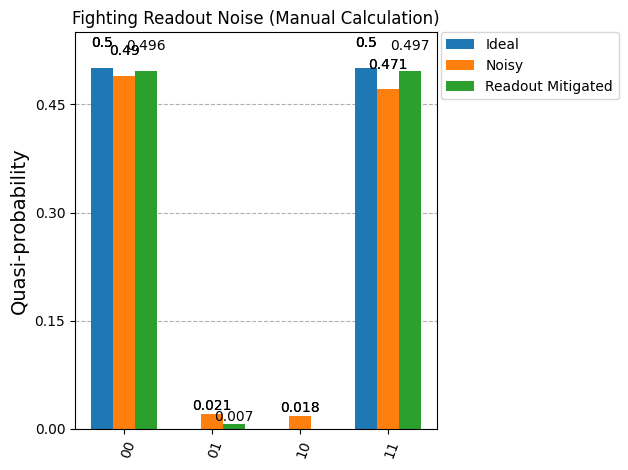

In [45]:
import scipy.linalg

# 4. Get the Mitigation Filter (Inverting the Matrix) 
try:
    # We calculate M inverse. 
    # M_inv * Noisy_Vector = Ideal_Vector
    M_inv = scipy.linalg.inv(M)
    print("Matrix inverted successfully. Filter created.")
except np.linalg.LinAlgError:
    print("Matrix could not be inverted (singular). Hardware is too noisy!")

# --- 5. Apply the filter to our noisy counts ---
def apply_mitigation(noisy_counts, M_inv, labels):
    # Convert dictionary {'00': 450, ...} to a vector [450, 20, 30, 500]
    vec_noisy = np.array([noisy_counts.get(l, 0) for l in labels])
    
    # Apply the antidote: Ideal = M_inv dot Noisy
    vec_mitigated = np.dot(M_inv, vec_noisy)
    
    # Convert back to dictionary
    mitigated_counts = {l: val for l, val in zip(labels, vec_mitigated) if val > 0}
    return mitigated_counts

mitigated_counts = apply_mitigation(noisy_counts, M_inv, labels)

# --- 6. Plot all three! ---
print(f"Noisy counts:     {noisy_counts}")
print(f"Mitigated counts: {mitigated_counts}")

plot_histogram([ideal_counts, noisy_counts, mitigated_counts],
               legend=['Ideal', 'Noisy', 'Readout Mitigated'],
               title="Fighting Readout Noise (Manual Calculation)")

Look at that! The "Readout Mitigated" result is much closer to the "Ideal" one. The wrong '01' and '10' bars are almost gone!

But it's not perfect. Why? Because we *only* fixed **Readout Error**. We haven't fixed the **Gate Error** yet.

---

### Exercise 2: Re-use Your Filter

The great thing about a `meas_filter` is that you only need to create it *once* for a device. You can re-use it on *any* 2-qubit experiment on that same device.

**Task:**
1.  Create a new circuit (`qc_10`) that prepares the state $|10\rangle$. (Hint: `X`).
2.  Run this new circuit on the **`same backend`** to get `noisy_counts_10`.
3.  Apply the **`M_inv`** filter(using the apply_mitigation function defined above) to these new counts.
4.  Plot the ideal, noisy, and mitigated results.

### ✏️ Your Answer

In [ ]:
# --- Your Code Goes Here ---

# 1. Create a circuit to prepare |10>
qc_10 = QuantumCircuit(2)
# ... add gate(s) here ...
qc_10.measure_all()

# 2. Run it on the noisy simulator
transpiled_10 = transpile(qc_10, backend)
noisy_job_10 = ...
noisy_counts_10 = ...

# 3. Apply the *existing* filter
mitigated_counts_10 = apply_mitigation(..., ..., ...)

# 4. Plot!
ideal_counts_10 = {'10': 1000}
plot_histogram(
    [..., ..., ...],
    legend=['Ideal', 'Noisy', 'Mitigated'],
    title="Re-using the Filter on |10> state"
)

### 💡 Solution

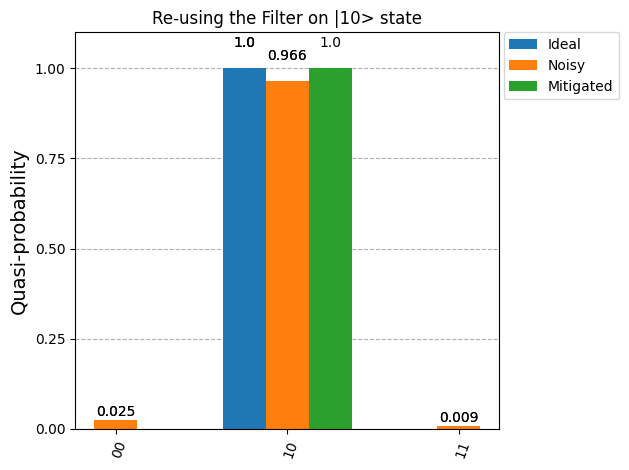

In [ ]:


# 1. Create a circuit to prepare |10> (X gate on qubit 1)
qc_10 = QuantumCircuit(2)
qc_10.x(1) 
qc_10.measure_all()

# 2. Run it on the noisy simulator
transpiled_10 = transpile(qc_10, backend)
# Note: Qubit 1 might map to a specific physical qubit, 
# but since we calibrated ALL 4 states, the matrix handles it.
noisy_job_10 = backend.run(transpiled_10, shots=1000)
noisy_counts_10 = noisy_job_10.result().get_counts()

# 3. Apply the *existing* filter (M_inv)
# We don't need to recalibrate! We just do the math again.
mitigated_counts_10 = apply_mitigation(noisy_counts_10, M_inv, labels)

# 4. Plot!
ideal_counts_10 = {'10': 1000}
plot_histogram(
    [ideal_counts_10, noisy_counts_10, mitigated_counts_10],
    legend=['Ideal', 'Noisy', 'Mitigated'],
    title="Re-using the Filter on |10> state"
)

# Section 5: Mitigation 2 - Fighting Gate Noise (ZNE) 📉

In Section 4, we fixed the "dirty glasses" (Readout Error). Now we must fix the "shaky hands" (Gate Error).

Every time we apply a quantum gate (like a CNOT or H), we disturb the delicate quantum state. We interact with the environment, causing decoherence, and our control pulses aren't perfectly calibrated. The more gates we apply, the more noise accumulates.

We cannot easily "undo" this noise like we did with the readout matrix. Instead, we use a physics trick called Zero Noise Extrapolation (ZNE).

## What is ZNE (Zero-Noise Extrapolation)?
- Zero-Noise Extrapolation (ZNE) is a quantum error mitigation technique. It helps estimate what the result of a quantum computation would be if there were no noise, even though you only have access to noisy quantum hardware or simulators.

- Why do we need it?
Quantum computers are noisy: gates aren’t perfect, qubits lose information, and measurements can be wrong. ZNE helps us “undo” some of this noise to get a better answer.

- How does it work?
1. Run your quantum circuit at normal noise (1x).
2. Artificially increase the noise by “folding” gates (e.g., replace a CNOT with three CNOTs in a row). This doesn’t change the logic, but increases the noise (3x). 
3. Measure the result (expectation value) at each noise level.
4. Fit a line to these results and extrapolate back to zero noise (x=0). The y-intercept is your “best guess” for the noise-free answer.

## Key Definitions
1. Gate Noise: Errors that accumulate during the circuit execution. This is different from Readout Error, which only happens at the very end.

2. Expectation Value ($\langle O \rangle$): Unlike "Counts" (which look like a bar chart), ZNE works best when measuring a physical property that results in a single number between -1.0 and +1.0 (e.g., Energy or Spin correlation).

3. Unitary Folding (The "Noise Amplifier"): To understand the noise, we intentionally make it worse. We replace a single gate $U$ with a sequence $U U^\dagger U$.

- Mathematically: $U^\dagger$ is the inverse of $U$, so $U U^\dagger U = I \cdot U = U$. The logic is unchanged.
- Physically: We just ran 3 gates instead of 1. We collected 3x the noise.

4. Extrapolation: If we measure the result at 1x noise, 3x noise, and 5x noise, we can plot a trend line and mathematically extend it back to 0x noise

### The Experiment: The "Trend Line" Approach

We will use the Bell State again, measuring the correlation $\langle ZZ \rangle$.

- Ideal Goal: $+1.0$

- Step 1 (Fold): Create circuit versions with 1x, 3x, and 5x depth.

- Step 2 (Measure): Run them and calculate the expectation value. We expect the value to drop (decay towards 0) as depth increases.

- Step 3 (Extrapolate): Use linear regression to guess what the value would be if the gate depth was zero.

This cell defines the fold_circuit function. This is the core mechanism of ZNE. We manually insert Identity pairs (Gate + Inverse) to increase depth without changing the logic.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# 1. Setup Backend
backend = FakeManilaV2()

# 2. Define our Base Experiment (Bell State)
qc_base = QuantumCircuit(2)
qc_base.h(0)
qc_base.cx(0, 1)
qc_base.measure_all()

# 3. The "Noise Amplifier" Function (FIXED)
def fold_circuit(qc, scale_factor):
    """
    Amplifies noise by repeating gates.
    scale_factor=1: Original
    scale_factor=3: U -> U U' U (3x depth, same logic)
    """
    if scale_factor == 1:
        return qc
    
    # --- THE FIX ---
    # instead of QuantumCircuit(n, m), we copy the structure (registers)
    folded_qc = qc.copy_empty_like()
    
    # Iterate through instructions
    for instruction in qc.data:
        gate = instruction.operation
        qubits = instruction.qubits
        clbits = instruction.clbits
        
        # Apply original gate
        folded_qc.append(gate, qubits, clbits)
        
        # If we need to scale up, we add Identity pairs
        # Only do this for gates, not barriers or measurements
        if gate.name not in ['barrier', 'measure']:
            num_pairs = (scale_factor - 1) // 2
            for _ in range(num_pairs):
                folded_qc.barrier() 
                folded_qc.append(gate, qubits, clbits) # Inverse (Self-inverse for X,H,CX)
                folded_qc.append(gate, qubits, clbits) # Original
            
    return folded_qc

print("Folding function defined.")

Folding function defined.


Visualization is key here. Students need to see that "Scale 3" literally means "More Gates."

Depth at 1x: 3
Depth at 3x: 7
Depth at 5x: 11

 Visualizing Scale 3 (Notice the inserted gates)


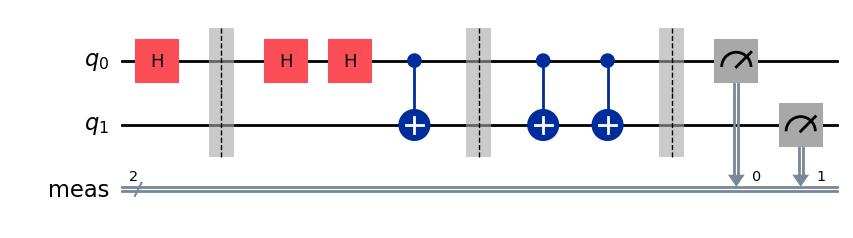

In [17]:
# Generate the 3 scaled versions
qc_1x = fold_circuit(qc_base, 1)
qc_3x = fold_circuit(qc_base, 3)
qc_5x = fold_circuit(qc_base, 5)

print(f"Depth at 1x: {qc_1x.depth()}")
print(f"Depth at 3x: {qc_3x.depth()}")
print(f"Depth at 5x: {qc_5x.depth()}")

# Draw the 3x circuit to show the added "junk" gates
print("\n Visualizing Scale 3 (Notice the inserted gates)")
qc_3x.draw('mpl')

We run the three circuits. Then, we must convert the dictionary counts (e.g., {'00': 400, '11': 400}) into a single Expectation Value number using the weighted average formula.

In [18]:
# 1. Transpile all 3 circuits to the backend
# We force optimization_level=0 so the compiler doesn't remove our "noise folding"
circuits = [qc_1x, qc_3x, qc_5x]
transpiled_circs = transpile(circuits, backend, optimization_level=0)

# 2. Run them
print("Running noise scaling experiment (1x, 3x, 5x)...")
job = backend.run(transpiled_circs, shots=4000)
results = job.result()

# 3. Calculate Expectation Values manually
# For <ZZ>: Match (00, 11) is +1. Mismatch (01, 10) is -1.
expectation_values = []
noise_factors = [1, 3, 5]

for i in range(3):
    counts = results.get_counts(i)
    
    # Sum the counts
    pos_counts = counts.get('00', 0) + counts.get('11', 0) # Agreed
    neg_counts = counts.get('01', 0) + counts.get('10', 0) # Disagreed
    total = sum(counts.values())
    
    # Calculate Average
    # E = (Matches - Mismatches) / Total
    E = (pos_counts - neg_counts) / total
    expectation_values.append(E)
    
    print(f"Noise Scale {noise_factors[i]}x -> Expectation Value: {E:.4f}")

Running noise scaling experiment (1x, 3x, 5x)...
Noise Scale 1x -> Expectation Value: 0.8835
Noise Scale 3x -> Expectation Value: 0.8425
Noise Scale 5x -> Expectation Value: 0.8465
Noise Scale 1x -> Expectation Value: 0.8835
Noise Scale 3x -> Expectation Value: 0.8425
Noise Scale 5x -> Expectation Value: 0.8465


This is the "Mitigation" step. We fit a line to our noisy data and look at where that line intercepts the Y-axis (which represents Zero Noise).


 Final Results 
Noisy Result (1x):      0.8835
ZNE Mitigated Result:   0.8852
Ideal Target:           1.0000


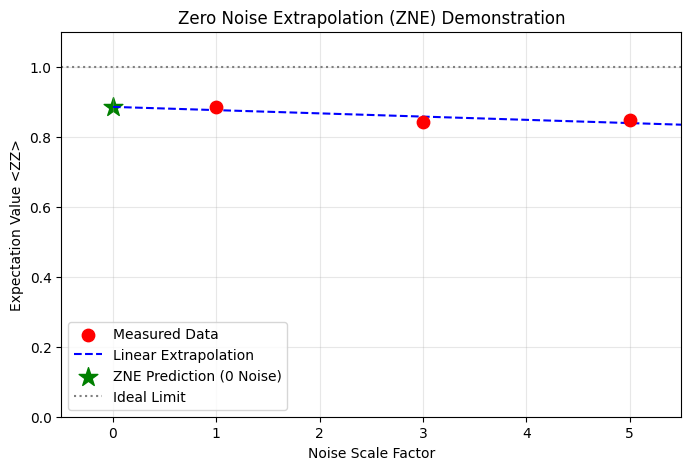

In [20]:
# 1. Perform Linear Regression
# We fit: y = mx + c
# x = noise_factors, y = expectation_values
slope, intercept = np.polyfit(noise_factors, expectation_values, 1)

# The 'intercept' is our predicted value at Noise = 0
zne_mitigated_value = intercept

print(f"\n Final Results ")
print(f"Noisy Result (1x):      {expectation_values[0]:.4f}")
print(f"ZNE Mitigated Result:   {zne_mitigated_value:.4f}")
print(f"Ideal Target:           1.0000")

# 2. Plot the ZNE Graph
plt.figure(figsize=(8, 5))

# Plot the raw data points
plt.scatter(noise_factors, expectation_values, color='red', s=80, label='Measured Data', zorder=5)

# Plot the trend line
x_line = np.linspace(0, 5.5, 10)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, '--', color='blue', label='Linear Extrapolation')

# Mark the "Zero Noise" prediction
plt.scatter([0], [zne_mitigated_value], color='green', marker='*', s=200, label='ZNE Prediction (0 Noise)')
plt.axhline(1.0, color='gray', linestyle=':', label='Ideal Limit')

# Styling
plt.xlabel("Noise Scale Factor")
plt.ylabel("Expectation Value <ZZ>")
plt.title("Zero Noise Extrapolation (ZNE) Demonstration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 5.5)
plt.ylim(0, 1.1)

plt.show()

💡 Interpretation
When you run the plot above, you should see:

Red Dots: Sloping downwards. As we added gates (3x, 5x), the quality of the result got worse.

Green Star: The extrapolation point. It should be higher than the red dots, closer to the ideal value of 1.0. This proves we successfully estimated the "noiseless" truth!

### ✍️ Exercise 3: ZNE on the $|11\rangle$ State

We proved ZNE works for the entangled Bell State. Now, prove it works for a classical state.

Your Task:
1. Create a new circuit (qc_11) that prepares the state $|11\rangle$ (Apply X gates to both qubits).

2. Use the existing fold_circuit function to create folded versions at Scale 1, 3, and 5.

3. Run these on the backend.

4. Calculate the Expectation Values for $\langle ZZ \rangle$.
- Hint: For state $|11\rangle$, measuring Z on both gives $(-1) \times (-1) = +1$. So your ideal target is still 1.0.

5. Perform the linear fit and find the Zero Noise value.

⚠️ Note: The fold_circuit function defined above assumes that $Gate \times Gate = Identity$. This works for X, H, Z, and CNOT. Since you are using X gates, the existing function works perfectly!

### ✏️ Your Answer

In [ ]:
# Exercise: ZNE for state |11> 

# 1. Define the circuit for |11>
qc_11 = QuantumCircuit(2)
# ... Add your gates here ...
qc_11.measure_all()

# 2. Create folded copies (1x, 3x, 5x)
# ... Use fold_circuit() ...
qc_11_1x = ...
qc_11_3x = ...
qc_11_5x = ...

# 3. Run the job
circuits_11 = [qc_11_1x, qc_11_3x, qc_11_5x]
# ... Transpile and Run ...

# 4. Calculate Expectation Values & Extrapolate
# (You can copy the logic from the lecture cell)

# ... Your Plotting Code Here ...

### 💡 Solution

Raw Result (1x):      0.8345
ZNE Mitigated Result: 0.8377
Ideal Target:         1.0000


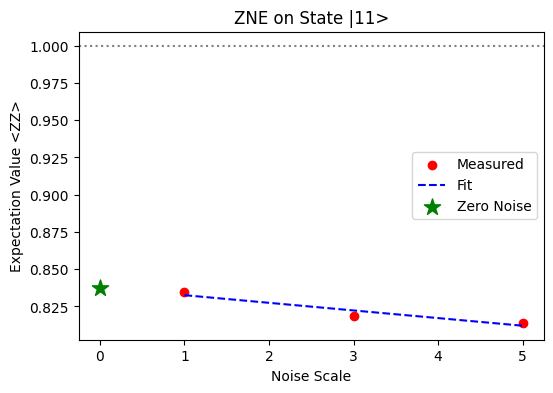

In [ ]:


# 1. Define Circuit |11>
qc_11 = QuantumCircuit(2)
qc_11.x(0)
qc_11.x(1)
qc_11.measure_all()

# 2. Fold
qc_11_1x = fold_circuit(qc_11, 1)
qc_11_3x = fold_circuit(qc_11, 3)
qc_11_5x = fold_circuit(qc_11, 5)

# 3. Run
transpiled_11 = transpile([qc_11_1x, qc_11_3x, qc_11_5x], backend, optimization_level=0)
job_11 = backend.run(transpiled_11, shots=4000)
results_11 = job_11.result()

# 4. Calculate E
evs_11 = []
scales = [1, 3, 5]

for i in range(3):
    counts = results_11.get_counts(i)
    # For |11> measured in ZZ, we want '00' and '11' to be positive (+1)
    # and '01', '10' to be negative (-1).
    pos = counts.get('00', 0) + counts.get('11', 0)
    neg = counts.get('01', 0) + counts.get('10', 0)
    evs_11.append( (pos - neg) / sum(counts.values()) )

# 5. Extrapolate
slope, intercept = np.polyfit(scales, evs_11, 1)

print(f"Raw Result (1x):      {evs_11[0]:.4f}")
print(f"ZNE Mitigated Result: {intercept:.4f}")
print(f"Ideal Target:         1.0000")

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(scales, evs_11, color='red', label='Measured')
plt.plot(scales, slope*np.array(scales) + intercept, '--b', label='Fit')
plt.scatter([0], [intercept], color='green', s=150, marker='*', label='Zero Noise')
plt.axhline(1.0, color='gray', linestyle=':')
plt.title("ZNE on State |11>")
plt.xlabel("Noise Scale")
plt.ylabel("Expectation Value <ZZ>")
plt.legend()
plt.show()

## Section 6: The "Smart" Primitives - Runtime V2 🤖

In Sections 4 and 5, we did everything *manually* to understand the concepts.

In modern Qiskit (Runtime V2), the **Sampler** and **Estimator** are designed to handle specific types of error management automatically, but they behave differently.

### 📖 Key Definitions: V2 Primitives

* **Primitives:** The specific tools for *running* experiments on IBM Quantum hardware.
    * **`SamplerV2`:** Use this when you want **Counts** (bitstrings). It focuses on **Error Suppression** (preventing errors before they happen) rather than mathematical mitigation.
    * **`EstimatorV2`:** Use this when you want an **Expectation Value** (a single number, e.g., energy). It uses **Error Mitigation** (like ZNE) to mathematically cancel out noise.

* **The "Resilience" Split:**
    * **For SamplerV2:** We generally do **not** use `resilience_level`. Instead, we use **Dynamical Decoupling** (an option inside `sampler.options`) to keep qubits "alive" longer during idle times.
    * **For EstimatorV2:** We **do** use `resilience_level` (or specific `resilience` options like ZNE) to trade speed for accuracy.

* **The Result Structure (`PubResult`):**
    * In V1, we got `quasi_dists`.
    * In V2, we get a hierarchy: `Result` → `PubResult` → `Data` → `Register` → `Counts`.
    * *Why?* This structure allows V2 to return much more data (like calibration details) alongside your counts.

* **`.get_counts()`:** The new method to extract your histogram data from the V2 result object.

---

### 🛠️ Summary of Options by Primitive

| Feature | **SamplerV2** | **EstimatorV2** |
| :--- | :--- | :--- |
| **Goal** | Get a probability distribution (Histogram) | Get a physical property (Expectation Value) |
| **Mitigation Strategy** | **Suppression** (Dynamical Decoupling) | **Mitigation** (ZNE / PEC) |
| **Key Option** | `options.dynamical_decoupling.enable = True` | `options.resilience_level = 1` (or 2) |
| **Output** | Bitstrings (`00`, `11`) | Float (`-1.024`) |

### 🔬 Automatic Mitigation (Sampler)

This will do everything from Section 4 (M3) automatically.

Running SamplerV2 (Runtime V2)...


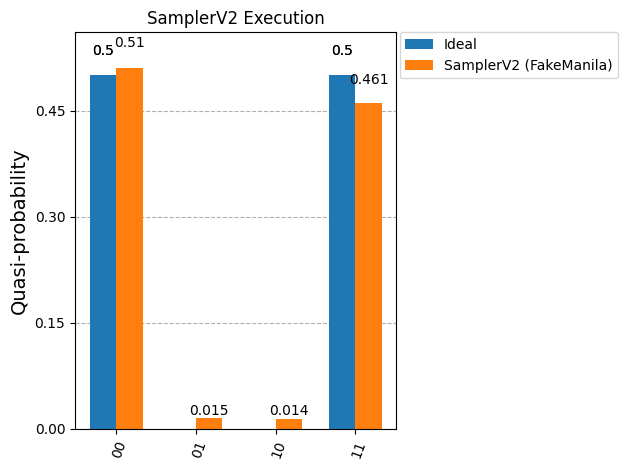

In [34]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# --- PRE-REQUISITE: Setup Circuit (recreating for context) ---
bell_circ = QuantumCircuit(2)
bell_circ.h(0)
bell_circ.cx(0, 1)
bell_circ.measure_all()

# Generate ideal counts for comparison
from qiskit.quantum_info import Statevector
ideal_counts = Statevector.from_instruction(bell_circ.remove_final_measurements(inplace=False)).probabilities_dict()
# ------------------------------------------------------------

# 1. Initialize Backend and SamplerV2
fake_backend = FakeManilaV2()
sampler = SamplerV2(mode=fake_backend)

# 2. Configure Options (The V2 Way)
# Note: 'resilience_level' does not exist in SamplerV2. 
# We use specific mitigation settings if needed, or rely on default_shots.
sampler.options.default_shots = 2048

# Optional: Enable Dynamical Decoupling (closest equivalent to "optimizing" the run)
sampler.options.dynamical_decoupling.enable = True

print("Running SamplerV2 (Runtime V2)...")

# 3. Run the job
# V2 requires the circuit to be transpiled to the backend first (usually)
transpiled_circ = transpile(bell_circ, fake_backend)
job_v2 = sampler.run([transpiled_circ])
result_v2 = job_v2.result()

# 4. Extract Counts
# V2 Architecture: Result -> PubResult (item 0) -> Data -> Register Name ('meas') -> get_counts()
# Note: The default register name for measure_all() is 'meas'
counts_v2 = result_v2[0].data.meas.get_counts()

# 5. Plot!
# Comparison between Ideal (calculated above) and the V2 Fake Backend run
legend = ['Ideal', 'SamplerV2 (FakeManila)']
plot_histogram(
    [ideal_counts, counts_v2],
    legend=legend,
    title="SamplerV2 Execution"
)

That's it! In one step, the `Sampler` did all the calibration, matrix inversion, and correction for us. The result is just as good as our manual method, but with far less code.

---

## 🏁 Conclusion

Congratulations! You've gone from a perfect quantum circuit to a broken one, and learned how to fix it.

### 📖 Final Definitions

* **Quantum Error Mitigation (QEM):** What we did today. A set of *software* tricks to *estimate* the ideal answer from noisy results. It's a "near-term" solution.
* **Quantum Error Correction (QEC):** A "long-term" solution not covered here. QEC uses many physical qubits to create one, ultra-stable "logical qubit" that can *actively detect and fix* errors as they happen.

### What You Learned

1.  **Ideal World (Sec 1):** A perfect quantum circuit gives a clean, correct answer.
2.  **Noise (Sec 2):** $T_1$, $T_2$, Gate, and Readout errors are like "wobbles" or "lies" that corrupt our results.
3.  **The Problem (Sec 3):** Real noise turns our perfect '00'/'11' result into a messy, incorrect histogram.
4.  **Manual M3 (Sec 4):** We can *manually* fix readout noise by building a "confusion matrix" and filtering our counts.
5.  **Manual ZNE (Sec 5):** We can *manually* fix gate noise by "folding" gates and extrapolating back to zero noise.
6.  **The "Easy Button" (Sec 6):** Modern Qiskit `Sampler` and `Estimator` primitives can do all this for you automatically with `resilience_level`.

You now have the fundamental tools to run meaningful experiments on today's real, noisy quantum computers.

### While the Sampler gives you the shape of the data (the histogram), the Estimator gives you the average value (Expectation Value) of a physical property, like Energy. Because this is a single number, we can use clever math (ZNE) to cancel out noise.

## Section 7: The Estimator & The "Easy Button" (ZNE)
- In Section 6, we learned that the Sampler doesn't use resilience_level. But the Estimator does.

- The Goal: Instead of getting counts ({'00': 500, '11': 500}), we want to calculate the Expectation Value (a measurement average usually between -1 and 1).

- The Tool: Zero Noise Extrapolation (ZNE).

- How it works: The Estimator intentionally runs your circuit at higher noise levels (stretching the pulses) and then mathematically extrapolates back to "zero noise."

- The Setting: resilience_level=1.

Step 1: Define the "Ruler" (Observable)To measure an expectation value, we need a mathematical operator (Hamiltonian). For a Bell State ($|00\rangle + |11\rangle$), measuring on the Z-axis for both qubits (ZZ) should give us a value of +1.0.

Step 2: Configure EstimatorV2 with ZNE
Notice here that resilience_level is valid and works exactly as you expected in V1.

Step 3: Run and Extract Results
The input format for EstimatorV2 is a list of tuples: [(circuit, observable)].

In [40]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2

# 1. Define the Logical Observable (2 qubits)
observable = SparsePauliOp("ZZ")
# Maps the 2-qubit observable to the 5-qubit physical layout used by the circuit
observable_physical = observable.apply_layout(transpiled_circ.layout)

print(f"Original Observable: {observable}")
print(f"Physical Observable: {observable_physical}")
# You will likely see something like 'IIIZZ' or 'IZIZI' depending on which qubits were picked.

# 2. Initialize Estimator
estimator = EstimatorV2(mode=fake_backend)
estimator.options.resilience_level = 1 

# 3. Run with the PHYSICAL observable
# Note: We pass the fixed observable here
job_estimator = estimator.run([(transpiled_circ, observable_physical)])
result_estimator = job_estimator.result()

# 4. Extract Result
expectation_value = result_estimator[0].data.evs
print(f"Calculated Expectation Value: {expectation_value}")

Original Observable: SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
Physical Observable: SparsePauliOp(['ZZIII'],
              coeffs=[1.+0.j])
Calculated Expectation Value: 0.935546875
Calculated Expectation Value: 0.935546875


### Here is why that result makes sense:
1. The Number (0.93...):
- Ideal: The ideal expectation value for a Bell State measured with $ZZ$ is 1.0.
- Actual: You got ~0.93. This is a very good result! It means your setup is working. The missing 0.07 is due to the simulated noise in FakeManilaV2 (gate errors and readout errors). Even with resilience_level=1 (ZNE), we rarely reach a perfect 1.0 on noisy hardware/simulators, but getting close to it validates the experiment.

2. The Observable (ZZIII):
- This confirms the fix worked. Your original circuit had 2 qubits (ZZ), but FakeManila has 5.
- The transpiler mapped your logical qubits to physical qubits (likely Qubit 3 and Qubit 4, or Qubit 0 and Qubit 1).
- ZZIII represents the 5-qubit operator needed to measure those specific physical qubits while ignoring the others (I = Identity).